# Find brightest donut with qm. Cutout with `cutOutDonuts`. 

In [ ]:
Run with `ts_wep` v4.0.3

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
from lsst.daf import butler as dafButler

from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import (
    CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig
)
from lsst.ts.wep.task.CalcZernikesTask import (
    CalcZernikesTask, CalcZernikesTaskConfig)

from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
butler = dafButler.Butler('/sdf/data/rubin/repo/main/')
year='2022'
monthDay='0407'

collection='u/scichris/Latiss/DM-37269'
datasetRefOrType = 'postISRCCD'
exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                 'exposure':int(f'{year}{monthDay}00156')
                                    },
                  collections=[collection])
exposure_extra =  butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                 'exposure':int(f'{year}{monthDay}00157')
                                    },
                  collections=[collection])

## Detect brightest donut with qm

In [5]:
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)


side = 120
result_intra= qm.run(exposure_intra, donutDiameter=2 * side)
result_extra = qm.run(exposure_extra, donutDiameter=2 * side)

INFO:lsst.quickFrameMeasurementTask:Found 43 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 43 of 43 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Found 23 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 23 of 23 sources in exposure


In [6]:
result_intra

Struct(success=True; brightestObjCentroid=(1698.0, 2094.0); brightestObjCentroidCofM=(1700.3419560208697, 2019.7809139254266); brightestObj_xXyY=(11.462921697822441, 22.017017969038562); brightestObjApFlux70=107898409.5595932; brightestObjApFlux25=24783832.233398438; medianXxYy=(0.09569795300376312, 0.27602916121951104))

## Create donut catalog

In [7]:
import pandas
from lsst.afw.geom import SkyWcs
from lsst.afw.image import ExposureF
from lsst.pipe.base.struct import Struct
def get_donut_catalog(result: Struct, wcs: SkyWcs) -> pandas.DataFrame:
    """Get the donut catalog, used by wep, from the quick frame measurement
    result.
    Parameters
    ----------
    result : `Struct`
        Result of `QuickFrameMeasurementTask`.
    wcs : `SkyWcs`
        Exposure WCS, to compute Ra/Dec.
    Returns
    -------
    donut_catalog : `pandas.DataFrame`
        Donut catalog.
    """
    ra, dec = wcs.pixelToSkyArray(
        result.brightestObjCentroidCofM[0],
        result.brightestObjCentroidCofM[1],
        degrees=False,
    )

    donut_catalog = pandas.DataFrame([])
    donut_catalog["coord_ra"] = ra
    donut_catalog["coord_dec"] = dec
    donut_catalog["centroid_x"] = [result.brightestObjCentroidCofM[0]]
    donut_catalog["centroid_y"] = [result.brightestObjCentroidCofM[1]]
    donut_catalog["source_flux"] = [result.brightestObjApFlux70]
    donut_catalog["blend_centroid_x"] = [list()]
    donut_catalog["blend_centroid_y"] = [list()]
    donut_catalog = donut_catalog.sort_values(
        "source_flux", ascending=False
    ).reset_index(drop=True)

    return donut_catalog

In [10]:
position_out_of_range = False
donut_catalog_intra = get_donut_catalog(result_intra, exposure_intra.getWcs())
donut_catalog_extra = get_donut_catalog(
    *(
        (result_extra, exposure_extra.getWcs())
        if position_out_of_range
        else (result_intra, exposure_intra.getWcs())
    )
)

In [11]:
donut_catalog_intra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,2.735358,-0.524907,1700.341956,2019.780914,1.078984e+08,[],[]


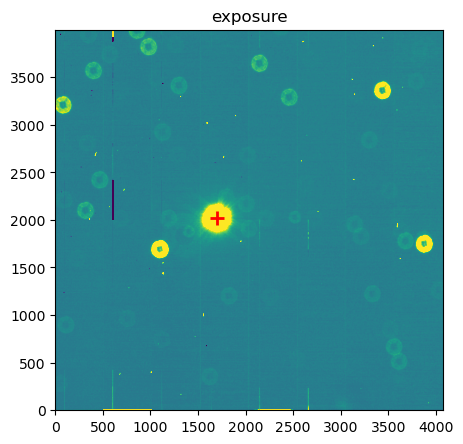

In [12]:
from astropy.visualization import ZScaleInterval

zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(5,5))

data = exposure_intra.image.array
vmin, vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,origin='lower',)
ax.set_title('exposure')

x = donut_catalog_intra['centroid_x'][0]
y = donut_catalog_intra['centroid_y'][0]
ax.scatter(x,y, marker='+', lw=2, s=100,c='r')

Show the location in the image given the donut catalog ... 

Text(0.5, 1.0, 'intra')

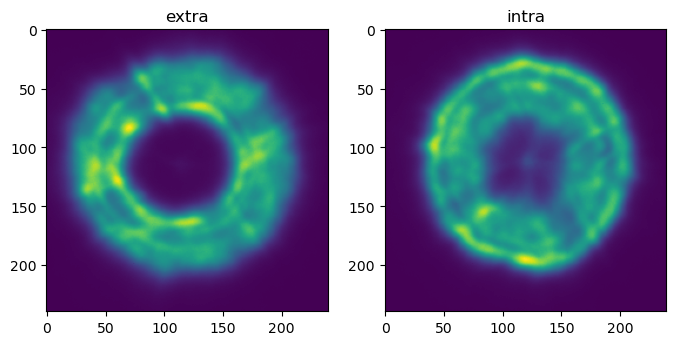

In [13]:
y = int(donut_catalog_intra['centroid_x'][0])
x = int(donut_catalog_intra['centroid_y'][0])
dx=120
dy=120
stamp_intra = exposure_intra.image.array[x-dx:x+dx,  y-dy:y+dy]

y = int(donut_catalog_extra['centroid_x'][0])
x = int(donut_catalog_extra['centroid_y'][0])

stamp_extra = exposure_extra.image.array[x-dx:x+dx,  y-dy:y+dy]


fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(stamp_extra)
ax[0].set_title('extra')
ax[1].imshow(stamp_intra)
ax[1].set_title('intra')

So the donut catalog position seems to be correct -  use that donut catalog to cut out stamps: 

## Use cutOutDonuts task

In [16]:
camera  = butler.get(
        "camera",
        dataId={"instrument": "LATISS"},
        collections="LATISS/calib/unbounded",
    )

cutOutDonutsConfig = CutOutDonutsScienceSensorTaskConfig()
cutOutDonutsConfig.donutStampSize = 200
cutOutDonutsConfig.donutTemplateSize = 200
cutOutDonutsConfig.initialCutoutPadding = 40
cutOutDonutsConfig.opticalModel = 'onAxis'

cutOutDonutsTask = CutOutDonutsScienceSensorTask(config=cutOutDonutsConfig)
struct = cutOutDonutsTask.run([exposure_intra, exposure_extra],
                         [donut_catalog_intra, donut_catalog_extra],
                             camera)



show the resulting donut stamps:

Text(0.5, 1.0, 'intra')

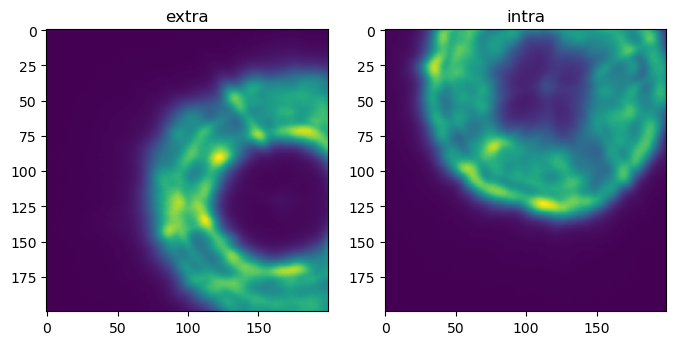

In [17]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(struct.donutStampsExtra[0].stamp_im.image.array)
ax[0].set_title('extra')
ax[1].imshow(struct.donutStampsIntra[0].stamp_im.image.array)
ax[1].set_title('intra')

Why are they so far off ? 